In [15]:
import pandas as pd
import pickle
import copy
import matplotlib.pyplot as plt
import networkx as nx

# Leitura e pré-processamento dos dados para a criação da matrix de localização

In [16]:
df = pd.read_csv('/home/gustavo/Desktop/Mestrado/mestrado_dados/dados_18.11/df_main_full.csv', index_col=False)
#df.drop(columns={'Unnamed: 0'}, inplace=True)

In [17]:
df.dropna(subset=['DATE'], inplace=True)
df['HOUR'] = df['HOUR'].apply(lambda x: str(x))
df['TIME_RANGE'] = [str(x.split(':')[0]) for x in df['HOUR']]

In [18]:
df['TIME_RANGE'] = df['TIME_RANGE'].apply(lambda x: int(x))
df['TIME_RANGE'].unique()

array([17, 15, 16, 22, 19, 13, 20, 14,  9,  7, 10, 11,  8, 18,  6, 12, 21,
        0,  2,  5,  4, 23,  1,  3])

In [19]:
df.loc[(df['DAY_OF_WEEK'] == 'Saturday') | (df['DAY_OF_WEEK'] == 'Sunday'), 'TIME_RANGE'] = df['TIME_RANGE'] + 24

In [20]:
df_2 = df.loc[df['classe'] == 2]
df_3 = df.loc[df['classe'] == 3]

In [21]:
df_reduced = df[['USER_FROM', 'ANTENNA_ID', 'TIME_RANGE']]
df_reduced_2 = df_2[['USER_FROM', 'ANTENNA_ID', 'TIME_RANGE']]
df_reduced_3 = df_3[['USER_FROM', 'ANTENNA_ID', 'TIME_RANGE']]

# Criação da matrix de localização

In [22]:
location_matrix = df_reduced.groupby([*df_reduced.columns]).size()
location_matrix = location_matrix.unstack([1,2]).stack(dropna=False).fillna(0, downcast='infer')

location_matrix_2 = df_reduced_2.groupby([*df_reduced_2.columns]).size()
location_matrix_2 = location_matrix_2.unstack([1,2]).stack(dropna=False).fillna(0, downcast='infer')

location_matrix_3 = df_reduced_3.groupby([*df_reduced_3.columns]).size()
location_matrix_3 = location_matrix_3.unstack([1,2]).stack(dropna=False).fillna(0, downcast='infer')

# Vetores de trajetória

In [27]:
trajectory_vector = location_matrix.groupby(['USER_FROM']).sum()
trajectory_vector_2 = location_matrix_2.groupby(['USER_FROM']).sum()
trajectory_vector_3 = location_matrix_3.groupby(['USER_FROM']).sum()

# Similaridade entre os vetores

In [28]:
import scipy.spatial.distance as ssd
import numpy as np

In [29]:
file = open('/home/gustavo/Desktop/Mestrado/mestrado_dados/Arquivos_Pickle/dict_edges.pkl', 'rb')
dict_edge = pickle.load(file)

In [30]:
def calculate_cosine_similarity(t_v, dict_edge):
    to_remove_dict = {}
    for key in dict_edge.keys():
        for k in key:
            if k in t_v.index:
                pass
            else:
                to_remove_dict[key] = dict_edge[key]
    tuples = set(dict_edge).difference(to_remove_dict)
    new_dict = {}
    for i in tuples:
        new_dict[i] = dict_edge[i]
    for key, value in zip(new_dict.keys(), new_dict.values()):
        x = t_v.loc[key[0]]
        y = t_v.loc[key[1]]
        cosine = 1 - ssd.cosine(x,y)
        value['Cosine_Similarity'] = cosine
    return new_dict

In [31]:
dt_geral = calculate_cosine_similarity(trajectory_vector, dict_edge)
dt_2 = calculate_cosine_similarity(trajectory_vector_2, dict_edge)
dt_3 = calculate_cosine_similarity(trajectory_vector_3, dict_edge)

In [32]:
t_v_2 = trajectory_vector_2.copy()
t_v_2['class'] = 2

t_v_3 = trajectory_vector_3.copy()
t_v_3['class'] = 3

t_v = t_v_3.append(t_v_2)
t_v.head()

ANTENNA_ID,LD1,MDM,RT,SJDR1,SJDR2,SJDR3,SJDR4,SJDR5,ST,SVM,TR1,TR2,class
USER_FROM,,,,,,,,,,,,,
00003F26576D1122848B6F3CEEC250E5,0,0,0,0,0,0,0,12,0,0,0,0,3
0008B8E32E18BF4450B7CAAF0C1CE179,0,0,0,27,0,0,0,0,0,0,0,0,3
000A16372A762FD3BB2A59334780CDEA,0,0,0,9,2,0,0,0,0,0,0,0,3
000D1DF8B25B4C1728D16E1510BC72BE,0,0,0,0,0,0,0,22,0,0,0,0,3
000DDDA8D62CC0A09B505AA27279CCF8,0,0,0,13,0,0,0,0,0,0,0,0,3


In [33]:
from itertools import chain
def dict_union(*args):
    return dict(chain.from_iterable(d.items() for d in args))

dicts = dict_union(dt_geral, dt_2, dt_3)

In [34]:
for k, v in dicts.items():
    v['class_node_1'] = t_v['class'][list(k)[0]]
    v['class_node_2'] = t_v['class'][list(k)[1]]

In [35]:
df_similarity_num_calls = pd.DataFrame.from_dict(dicts, orient='index').reset_index()
df_similarity_num_calls.rename(columns={'level_0': 'Node_1', 'level_1': 'Node_2'}, inplace=True)
df_similarity_num_calls.sample(5)

,Node_1,Node_2,num_calls,duration,Cosine_Similarity,class_node_1,class_node_2
14790,BF5C7E746717791A3372794878CCE100,68F428D278605BBBF29D649B15A13D39,3,0.71,0.000000,3,2
11255,9155AA84BE4976C62307A30EC89AF880,FECF26916874C4E0554A0FCE835BE51D,5,8.42,1.000000,2,2
4704,3DD356AB7E3CD8121E12BD00E1F9A2AA,25078F386B69CE4177DC58C58E005936,4,2.99,1.000000,3,3
9616,7C280BC6EE93F69EA3D4062ECA193100,A2565DD9C992025EF7F91EE6685B8C26,3,1.36,0.668608,3,3
19470,FA4860D4EEFC434FF473CA3A62C50A7B,9A51E4AF9A96C63EF6566AD9BB2A9EFB,8,5.23,0.999480,2,2


In [36]:
df_2_and_all = df_similarity_num_calls.loc[df_similarity_num_calls['class_node_1'] == 2]
df_2_and_2 = df_similarity_num_calls.loc[(df_similarity_num_calls['class_node_1'] == 2) & 
                                         (df_similarity_num_calls['class_node_2'] == 2)]
df_2_and_3 = df_similarity_num_calls.loc[(df_similarity_num_calls['class_node_1'] == 2) & 
                                         (df_similarity_num_calls['class_node_2'] == 3)]

df_3_and_all = df_similarity_num_calls.loc[df_similarity_num_calls['class_node_1'] == 3]
df_3_and_2 = df_similarity_num_calls.loc[(df_similarity_num_calls['class_node_1'] == 3) & 
                                         (df_similarity_num_calls['class_node_2'] == 2)]
df_3_and_3 = df_similarity_num_calls.loc[(df_similarity_num_calls['class_node_1'] == 3) & 
                                         (df_similarity_num_calls['class_node_2'] == 3)]

In [37]:
G = nx.read_gml('/home/gustavo/Desktop/Mestrado/mestrado_dados/Redes/redes_sjdr/sjdr_social_directed_no_null_outdegree_with_class.gml')


In [43]:
def sort_dataframes(dfs):
    new_df = []
    for df in dfs:
        #df = df.groupby(['Cosine_Similarity','num_calls']).first().reset_index()
        df = df.sort_values(by=['num_calls', 'Cosine_Similarity'])
        new_df.append(df)
    return new_df
df = sort_dataframes([df_2_and_2,df_2_and_3,df_2_and_all,df_3_and_2, df_3_and_3, df_3_and_all])

In [38]:
df_to_matrix = pd.DataFrame(index=['Class 2', 'Class 3'])
list_2 = [len(df_2_and_all.loc[df_2_and_all['class_node_2'] == 2])/len(df_2_and_all), 
          len(df_2_and_all.loc[df_2_and_all['class_node_2'] == 3])/len(df_2_and_all)]
df_to_matrix['Class 2'] = list_2

list_3 = [len(df_3_and_all.loc[df_3_and_all['class_node_2'] == 2])/len(df_3_and_all),
          len(df_3_and_all.loc[df_3_and_all['class_node_2'] == 3])/len(df_3_and_all)]
df_to_matrix['Class 3'] = list_3

df_to_matrix.style.background_gradient(cmap='Blues')

,Class 2,Class 3
Class 2,0.907564,0.0599059
Class 3,0.0924359,0.940094


In [45]:
for d in df:
    d['Reciprocity'] = ''
    for n, i in zip(d['Node_1'], d.index):
        d.at[i, 'Reciprocity'] = nx.reciprocity(G, n)

In [47]:
df_new = []
for d in df:
    #d = d[['num_calls', 'Cosine_Similarity']]
    d['Reciprocity'] = pd.to_numeric(d['Reciprocity'])
    df_new.append(d.groupby(['num_calls'])[['Cosine_Similarity', 'Reciprocity']].mean().reset_index())
    

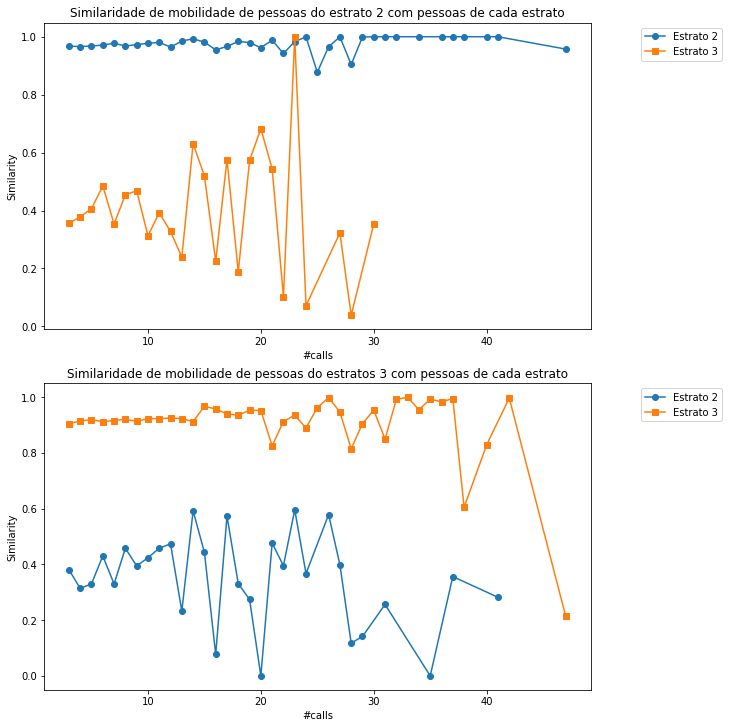

In [49]:
x1 = df_new[0]['num_calls'].to_numpy()
y1 = df_new[0]['Cosine_Similarity'].to_numpy()

x2 = df_new[1]['num_calls'].to_numpy()
y2 = df_new[1]['Cosine_Similarity'].to_numpy()

x3 = df_new[2]['num_calls'].to_numpy()
y3 = df_new[2]['Cosine_Similarity'].to_numpy()

_x1 = df_new[3]['num_calls'].to_numpy()
_y1 = df_new[3]['Cosine_Similarity'].to_numpy()

_x2 = df_new[4]['num_calls'].to_numpy()
_y2 = df_new[4]['Cosine_Similarity'].to_numpy()

_x3 = df_new[5]['num_calls'].to_numpy()
_y3 = df_new[5]['Cosine_Similarity'].to_numpy()

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,10), constrained_layout=True)

ax1.plot(x1, y1, label='Estrato 2',marker='o')
ax1.plot(x2, y2, label='Estrato 3',marker='s')
#ax1.plot(x3, y3, label='Todos os estratos')

ax1.set_xlabel('#calls')
ax1.set_ylabel('Similarity')

ax1.set_title('Similaridade de mobilidade de pessoas do estrato 2 com pessoas de cada estrato')
ax1.legend(loc="upper right", bbox_to_anchor=(1.25, 1))

ax2.plot(_x1, _y1, label='Estrato 2', marker='o')
ax2.plot(_x2, _y2, label='Estrato 3', marker='s')
#ax2.plot(_x3, _y3, label='Todos os estratos')

ax2.set_xlabel('#calls')
ax2.set_ylabel('Similarity')

ax2.set_title('Similaridade de mobilidade de pessoas do estratos 3 com pessoas de cada estrato')
ax2.legend(loc="upper right", bbox_to_anchor=(1.25, 1))


plt.savefig('/home/gustavo/Desktop/Mestrado/mestrado_dados/graficos/Similaridade_x_rank/Similridade_numcalss.png')
plt.show()

In [50]:
df_reciprocity = []
for df in df_new:
    df_reciprocity.append(df.sort_values(by=['Reciprocity']))

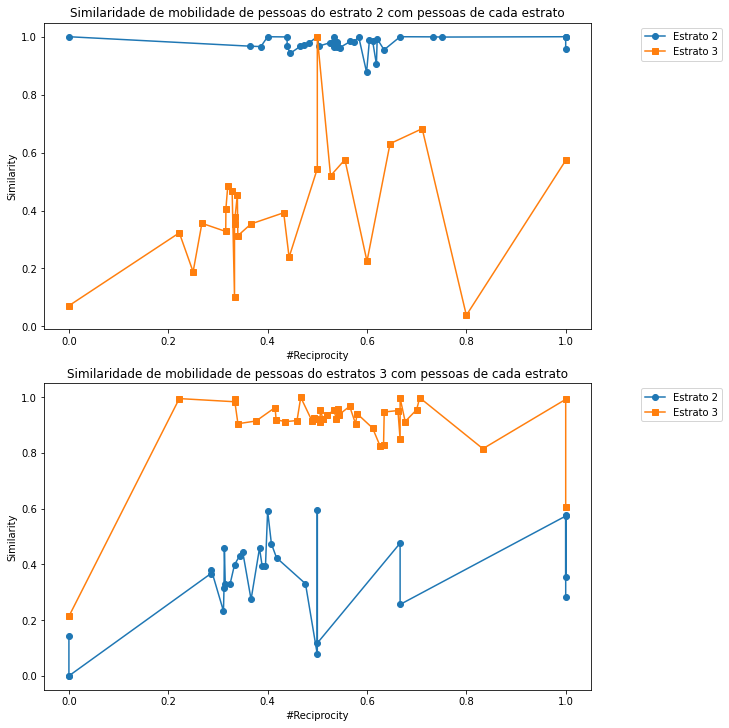

In [51]:
x1 = df_reciprocity[0]['Reciprocity'].to_numpy()
y1 = df_reciprocity[0]['Cosine_Similarity'].to_numpy()

x2 = df_reciprocity[1]['Reciprocity'].to_numpy()
y2 = df_reciprocity[1]['Cosine_Similarity'].to_numpy()

#x3 = df_reciprocity[2]['Reciprocity'].to_numpy()
#y3 = df_reciprocity[2]['Cosine_Similarity'].to_numpy()

_x1 = df_reciprocity[3]['Reciprocity'].to_numpy()
_y1 = df_reciprocity[3]['Cosine_Similarity'].to_numpy()

_x2 = df_reciprocity[4]['Reciprocity'].to_numpy()
_y2 = df_reciprocity[4]['Cosine_Similarity'].to_numpy()

#_x3 = df_reciprocity[5]['Reciprocity'].to_numpy()
#_y3 = df_reciprocity[5]['Cosine_Similarity'].to_numpy()

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,10), constrained_layout=True)

ax1.plot(x1, y1, label='Estrato 2', marker='o')
ax1.plot(x2, y2, label='Estrato 3', marker='s')
#ax1.plot(x3, y3, label='Todos os estratos', marker='p')

ax1.set_xlabel('#Reciprocity')
ax1.set_ylabel('Similarity')

ax1.set_title('Similaridade de mobilidade de pessoas do estrato 2 com pessoas de cada estrato')
ax1.legend(loc="upper right", bbox_to_anchor=(1.25, 1))

ax2.plot(_x1, _y1, label='Estrato 2', marker='o')
ax2.plot(_x2, _y2, label='Estrato 3', marker='s')
#ax2.plot(_x3, _y3, label='Todos os estratos', marker='p')

ax2.set_xlabel('#Reciprocity')
ax2.set_ylabel('Similarity')

ax2.set_title('Similaridade de mobilidade de pessoas do estratos 3 com pessoas de cada estrato')
ax2.legend(loc="upper right", bbox_to_anchor=(1.25, 1))

plt.savefig('/home/gustavo/Desktop/Mestrado/mestrado_dados/graficos/Similaridade_x_rank/Similridade_reciprocity.png')

plt.show()

In [52]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()

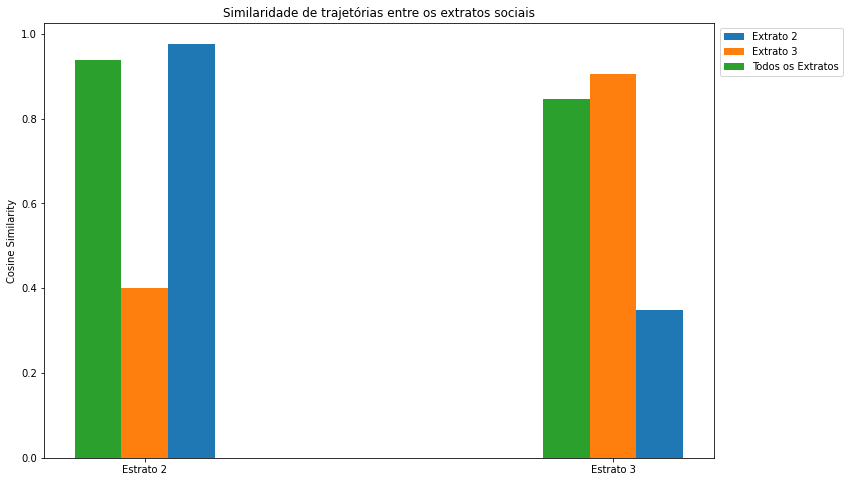

In [53]:
labels = ['Estrato 2', 'Estrato 3']

x = np.arange(len(labels))
width = 1

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x + 0.1, [np.mean(y1), np.mean(_y1)], width/10, label='Extrato 2')
rects2 = ax.bar(x, [np.mean(y2), np.mean(_y2)], width/10, label='Extrato 3')
rects3 = ax.bar(x - 0.1, [np.mean(y3), np.mean(_y3)], width/10, label='Todos os Extratos')

ax.set_ylabel('Cosine Similarity')
ax.set_title('Similaridade de trajetórias entre os extratos sociais')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.2, 1))

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


plt.show()